**1. IMPORT LIBRARIES**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from nltk import word_tokenize

**2. LOAD DATASET**

In [ ]:
data = pd.read_csv('sp_translated.csv')

**3. TOKENIZATION**

In [ ]:
import nltk  # don't forget to do this step everytime in colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['Text_tokenised'] = data['final_clean'].apply(word_tokenize)

**4. CREATE OWN WORD EMBEDDINGS**

In [ ]:
from gensim.models import Word2Vec

In [ ]:
source_list= []
for row in data['Text_tokenised']:
    source_list.append(row)

**Set parameters**

In [ ]:
model = Word2Vec(source_list, size=300, window=2, sg=0, hs =1, sorted_vocab= 1)
# summarize the loaded model
print(model)

Word2Vec(vocab=14832, size=300, alpha=0.025)


**Save model to .txt format**

In [ ]:
model.wv.save_word2vec_format('spanish_wv.txt', binary=False)  # binary=False turns it to a .bin

In [ ]:
# print the first few lines to check it out

a_file = open("spanish_wv.txt")
number_of_lines = 4

for i in range(number_of_lines):
    line = a_file.readline()
    print(line)

14832 300

ser 0.42901218 0.26419142 -0.30335584 -0.001050419 -0.26705787 -0.29602608 -0.08789363 -0.14788754 -0.22400741 -0.47360298 0.22132127 -0.0036134173 -0.074400984 0.063394256 -0.22855712 -0.51356965 -0.25366652 0.06175258 -0.4548032 0.19920842 -0.07096427 0.38088593 0.3602033 0.64936906 -0.122976534 0.015763558 0.40630093 -0.07647424 0.08673173 -0.42679825 -0.49776143 -0.51575667 0.11671314 0.2940461 0.38045081 -0.5101691 0.3507162 0.43731245 -0.056673743 0.3515425 -0.5001004 0.49367362 -0.38759625 -0.15572572 0.12132092 0.030579494 -0.08877814 -0.3826284 -0.6407746 -0.05508152 0.25368196 0.29245698 0.36897573 -0.23354222 0.62161 0.24564601 -0.09676414 0.38756472 -0.1836933 0.1668235 -0.4932714 0.23834094 0.2081495 -0.25651324 -0.1867685 -0.07057227 0.31621554 0.17141268 -0.6215968 0.16549985 0.19363923 0.44074413 -0.08015173 0.1537472 0.3550003 -0.11228214 -0.09211891 -0.17885868 0.37688175 -0.40664306 -0.3409852 -0.2946083 -0.31629997 0.09508711 0.05383221 0.13941646 -0.0481

**Create a dictionary**

In [ ]:
docs = data.final_clean.values
labels = data.Fake.values

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import Activation

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1  # I add one because it starts counting from 0

In [ ]:
import itertools
# see a slice of our dictionary
dict(itertools.islice(t.word_index.items(), 10))

{'año': 8,
 'decir': 7,
 'haber': 2,
 'hacer': 6,
 'nuevo': 9,
 'poder': 3,
 'primero': 10,
 'ser': 1,
 'tener': 4,
 'él': 5}

***5. SPLIT THE DATA***

In [ ]:
# divide the data into train/validate

from sklearn.model_selection import train_test_split


sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    docs, labels, test_size=0.20, random_state=1000)

***6. USE KERAS TOKENIZER TO CONVERT TRAIN AND VALID TO SEQUENCES***

In [ ]:
X_train = t.texts_to_sequences(sentences_train)
X_valid = t.texts_to_sequences(sentences_valid)


print(sentences_train[2])
print(X_train[2])

vei ois grito pues ser africo ser coloniaalemania mujer haber ser violar individuo violacion perpetrado manada inmigrante europa contar millon ocultar cifra real ocultar v
[53656, 53657, 2093, 446, 1, 14752, 1, 29839, 39, 2, 1, 1631, 2980, 3466, 13804, 9235, 757, 230, 98, 215, 1773, 1225, 223, 1773, 4553]


***7. POST-PADDING***

**Obtain the maximum length of each text**

In [ ]:
data['length'] = data['Text_tokenised'].str.len()

In [ ]:
maxlen = data['length'].max()

In [ ]:
maxlen

2806

**Pad short sequences**

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(X_train[1, :])

[ 2153 20089   138 ...     0     0     0]


***8. LOAD THE WHOLE EMBEDDING INTO MEMORY***

In [ ]:
embeddings_index = dict()
f = open('spanish_wv.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 14833 word vectors.


***9. CREATE A WEIGHT MATRIX FOR WORDS IN TRAINING ARTICLES***

In [ ]:
embedding_matrix = zeros((vocab_size, 300))  # create an empty numpy array which will be used as the embedding layer in our model with my dimensions 50 here
for word, i in t.word_index.items():  # go through our vocab integers and words
	embedding_vector = embeddings_index.get(word)  # find the word in the pretrained word vectors
	if embedding_vector is not None:  # if it is  not empty put it in our embedding matrix
		embedding_matrix[i] = embedding_vector


***10. BUILD THE MODEL***

In [ ]:
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam,SGD

model=Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(100)))  # one BLSTM Layer with 100 neurons 
model.add(Dropout(0.3)) # DROPOUT LAYER
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
adam=Adam(learning_rate=0.001)
model.compile(adam, loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2806, 300)         16179900  
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                6432      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,507,165
Trainable params: 327,265
Non-trainable params: 16,179,900
____________________________________

**11. TRAIN THE MODEL**

In [ ]:
# fit the model on the whole data
history = model.fit(X_train, y_train,
                    epochs=12,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=32)

Epoch 1/12
150/150 [==============================] - 52s 308ms/step - loss: 0.5086 - accuracy: 0.7356 - val_loss: 0.4349 - val_accuracy: 0.7750
Epoch 2/12
150/150 [==============================] - 45s 302ms/step - loss: 0.4478 - accuracy: 0.7856 - val_loss: 0.4115 - val_accuracy: 0.7983
Epoch 3/12
150/150 [==============================] - 45s 302ms/step - loss: 0.3950 - accuracy: 0.8142 - val_loss: 0.3944 - val_accuracy: 0.8117
Epoch 4/12
150/150 [==============================] - 45s 302ms/step - loss: 0.4058 - accuracy: 0.8071 - val_loss: 0.3976 - val_accuracy: 0.8158
Epoch 5/12
150/150 [==============================] - 45s 302ms/step - loss: 0.3528 - accuracy: 0.8335 - val_loss: 0.3715 - val_accuracy: 0.8225
Epoch 6/12
150/150 [==============================] - 45s 302ms/step - loss: 0.3621 - accuracy: 0.8375 - val_loss: 0.4033 - val_accuracy: 0.8292
Epoch 7/12
150/150 [==============================] - 45s 302ms/step - loss: 0.3164 - accuracy: 0.8610 - val_loss: 0.3760 - val_ac

**12. GRAPHIC REPRESENTATION**

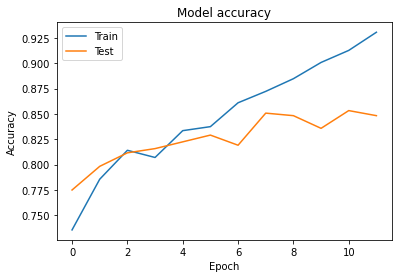

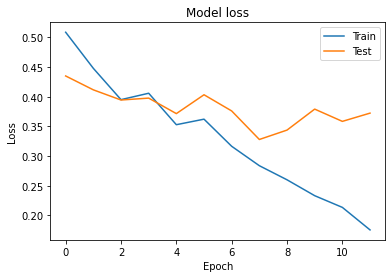

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

***13. METRICS***

In [ ]:
y_pred_valid=(model.predict(X_valid)>0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid,y_pred_valid))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       589
           1       0.88      0.81      0.84       611

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



In [ ]:
confusion_matrix(y_valid,y_pred_valid)

array([[524,  65],
       [117, 494]])